In [1]:
import pandas as pd # manipulating the csv file
import numpy as np # for mathematical calculations

In [2]:
train_data_m = pd.read_csv("PlayTennis.csv") 
train_data_m.head() 

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [3]:
#Calculate the entropy of the whole dataset

def calc_entropy(train_data, label, class_list):
  total_row = train_data.shape[0] #the shape of the data is a tuple.
  total_entr = 0
  for c in class_list:
    total_class_count = train_data[train_data[label]==c].shape[0]
    total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row)
    total_entr += total_class_entr
  return total_entr

In [4]:
# Calculate entropy for individual features

def calc_entropy_feature(feature_value_data, label, class_list):
  class_count = feature_value_data.shape[0]
  entropy = 0
  for c in class_list:
    label_count_class = feature_value_data[feature_value_data[label]==c].shape[0]
    entropy_class = 0
    if label_count_class != 0:
      probability_class = label_count_class/class_count
      entropy_class = - probability_class * np.log2(probability_class)
    entropy += entropy_class
  return entropy

In [5]:
# Calculating IG for a feature

def calc_ig(feature_name, train_data, label, class_list):
  feature_value_list = train_data[feature_name].unique()
  feature_row = train_data.shape[0]
  feature_info = 0.0

  for feature_value in feature_value_list:
    feature_value_data = train_data[train_data[feature_name]==feature_value]
    feature_value_count = feature_value_data.shape[0]
    feature_value_entropy = calc_entropy_feature(feature_value_data, label, class_list)
    feature_value_probability = feature_value_count/feature_row
    feature_info += feature_value_probability * feature_value_entropy

  return calc_entropy(train_data, label, class_list) - feature_info

In [6]:
# Find the highest information gain feature

def highest_ig(train_data, label, class_list):
  feature_list = train_data.columns.drop(label)
  max_info_gain = -1
  max_info_feature = None

  for feature in feature_list:
    feature_info_gain = calc_ig(feature, train_data, label, class_list)
    if max_info_gain < feature_info_gain:
      max_info_gain = feature_info_gain
      max_info_feature = feature

  return max_info_feature

In [7]:
# Adding a node or a subclass to the tree

def subtree(feature_name, train_data, label, class_list):
  feature_value_count = train_data[feature_name].value_counts(sort=False)
  tree = {}

  for feature_value, count in feature_value_count.items():
    feature_value_data = train_data[train_data[feature_name]==feature_value]
    assigned_to_node = False

    for c in class_list:
      class_count = feature_value_data[feature_value_data[label]==c].shape[0]

      if class_count == count:
        tree[feature_value] = c
        train_data = train_data[train_data[feature_name]!=feature_value]
        assigned_to_node = True

    if not assigned_to_node:
      tree[feature_value] = "?"

  return tree, train_data

In [8]:
# Generating tree

def generate_tree(root, prev_feature_value, train_data, label, class_list):
  if train_data.shape[0]!=0:
    max_info_feature = highest_ig(train_data, label, class_list)
    tree, train_data = subtree(max_info_feature, train_data, label, class_list)
    next_root = None

    if prev_feature_value!=None:
      root[prev_feature_value] = dict()
      root[prev_feature_value][max_info_feature] = tree
      next_root = root[prev_feature_value][max_info_feature]

    else:
      root[max_info_feature] = tree
      next_root = root[max_info_feature]

    for node, branch in list(next_root.items()):
      if branch == '?':
        feature_value_data = train_data[train_data[max_info_feature] == node]
        generate_tree(next_root, node, feature_value_data, label, class_list)

In [9]:
#Create a ID3 algorithm

def id3(train_data_m, label):
  train_data = train_data_m.copy()
  tree = {}
  class_list = train_data[label].unique()
  generate_tree(tree, None, train_data, label, class_list)
  return tree

In [10]:
# Start the id3

tree = id3(train_data_m,'Play Tennis')
print(tree)

{'Outlook': {'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}, 'Overcast': 'Yes', 'Rain': {'Wind': {'Weak': 'Yes', 'Strong': 'No'}}}}


In [11]:
# Predict the result from the tree

def predict(tree, instance):
  if not isinstance(tree, dict):
    return tree
  else:
    root_node = next(iter(tree))
    feature_value = instance[root_node]
    if feature_value in tree[root_node]:
      return predict(tree[root_node][feature_value], instance)
    else:
      return None

In [12]:
def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data_m.iterrows():
        result = predict(tree, test_data_m.iloc[index])
        if result == test_data_m[label].iloc[index]:
            correct_preditct += 1
        else:
            wrong_preditct += 1
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)
    return accuracy

In [13]:

test_data_m = pd.read_csv("PlayTennis.csv") #importing test dataset into dataframe

accuracy = evaluate(tree, test_data_m, 'Play Tennis') 
print("Accuracy: ", accuracy)

Accuracy:  1.0


In [14]:
from graphviz import Digraph

def add_nodes_edges(tree, dot=None):
    # Create Digraph object
    if dot is None:
        dot = Digraph()
        dot.node('root', str(next(iter(tree))), shape='box', style='filled', fillcolor='lightblue')
    
    # Root node
    root = next(iter(tree))
    
    for node, children in tree.items():
        if isinstance(children, dict):
            for value, child in children.items():
                if isinstance(child, dict):
                    # Add node
                    child_node = next(iter(child))
                    dot.node(str(child_node), str(child_node), shape='box', style='filled', fillcolor='lightblue')
                    # Add edge
                    dot.edge(str(node), str(child_node), label=str(value))
                    # Recursively add the rest of the nodes
                    add_nodes_edges(child, dot)
                else:
                    # Add leaf node
                    leaf_node = f"{node}_{value}_{child}"
                    dot.node(leaf_node, str(child), shape='ellipse', style='filled', fillcolor='lightgreen')
                    dot.edge(str(node), leaf_node, label=str(value))
    return dot

def plot_decision_tree(tree, filename='decision_tree'):
    dot = add_nodes_edges(tree)
    dot.format = 'png'
    dot.render(filename, view=True)
    return dot

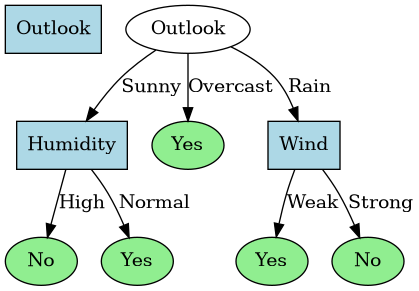

In [16]:
from IPython.display import Image
Image(dot.render('decision_tree', format='png'))